<a href="https://colab.research.google.com/github/Alfredsamson/Data-Science-project/blob/main/maize_diasease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTING THE MODULES**

In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import pandas as pd
IMAGE_SIZE = (256,256)
BATCH_SIZE = 32
CHANNELS = 3
EPOCHES= 100

# **IMPORTING THE IMAGE**

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/data (1)",
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 341 files belonging to 4 classes.


In [ ]:
import os
import glob as gb
path = "/content/drive/MyDrive/data (1)"
size=[]
for folder in os.listdir(path):
    files = gb.glob(pathname=str(path+"//"+folder+"/*.jpg"))
    for file in files:
        image=plt.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts()

(256, 256, 3)      50
(1600, 1200, 3)     4
(2448, 3264, 3)     3
(1125, 1500, 3)     2
(608, 1024, 3)      1
(404, 606, 3)       1
(374, 594, 3)       1
(300, 400, 3)       1
(279, 519, 3)       1
(2448, 2448, 3)     1
(255, 340, 3)       1
(267, 400, 3)       1
(3264, 1489, 3)     1
(335, 662, 3)       1
(1200, 1158, 3)     1
(3264, 2448, 3)     1
(1944, 2592, 3)     1
(1632, 1224, 3)     1
(395, 525, 4)       1
(1591, 743, 3)      1
(960, 1275, 3)      1
(299, 350, 3)       1
(611, 995, 3)       1
(200, 250, 3)       1
(339, 300, 3)       1
(3024, 4032, 3)     1
(500, 185, 3)       1
(480, 640, 3)       1
(371, 788, 3)       1
(482, 641, 3)       1
(421, 1080, 3)      1
(200, 300, 3)       1
(3071, 884, 3)      1
(463, 618, 3)       1
(1936, 2592, 3)     1
(414, 675, 3)       1
(240, 362, 3)       1
(237, 363, 3)       1
(2731, 1819, 3)     1
(612, 450, 3)       1
(334, 400, 3)       1
(675, 900, 3)       1
dtype: int64

In [ ]:
class_names = dataset.class_names
class_names

['Blight (1)', 'Common_Rust (1)', 'Gray_Leaf_Spot (1)', 'Healthy (1)']

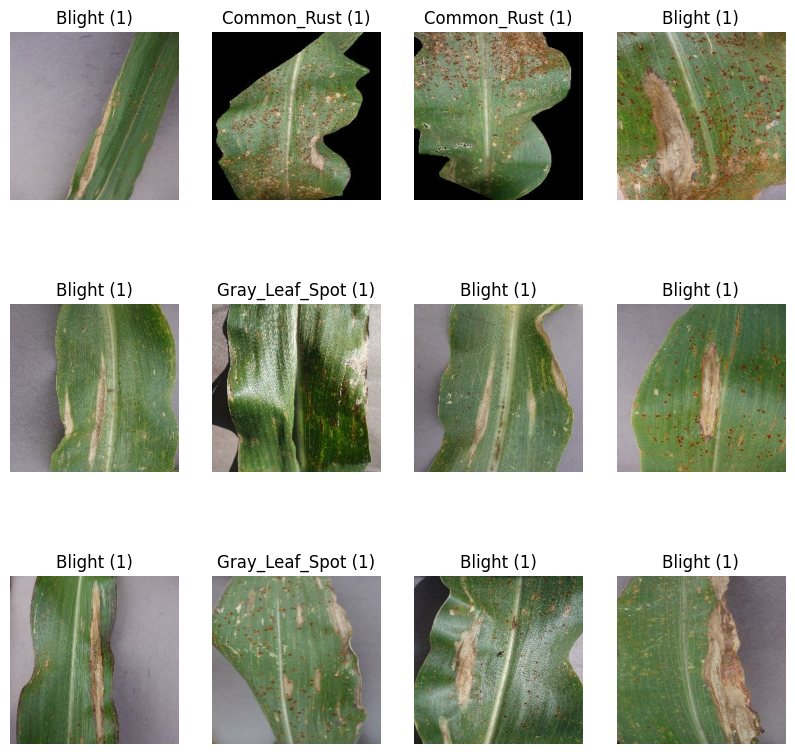

In [ ]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

# **DATA AUGUMENTATION**

In [ ]:
def get_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=8)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [ ]:
train_ds,val_ds,test_ds = get_dataset(dataset)

In [ ]:
print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))


Length of Training Dataset is 8

Length of Validation Dataset is 1

Length of Testing Dataset is 2


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(256,256),
layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.3),
])

# **BUILDING THE MODEL**

In [ ]:
n_classes = 4
input_shape = (BATCH_SIZE,256,256,3)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation ='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),

])
model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [ ]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

# **FITTING THE MODEL**

In [ ]:
history = model.fit(
train_ds,
epochs=90,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds)

Epoch 1/90
8/8 [==============================] - 37s 5s/step - loss: 0.1764 - accuracy: 0.9143 - val_loss: 0.3339 - val_accuracy: 0.8125
Epoch 2/90
8/8 [==============================] - 42s 5s/step - loss: 0.1814 - accuracy: 0.9224 - val_loss: 0.2526 - val_accuracy: 0.8750
Epoch 3/90
8/8 [==============================] - 38s 5s/step - loss: 0.1649 - accuracy: 0.9347 - val_loss: 0.2637 - val_accuracy: 0.8750
Epoch 4/90
8/8 [==============================] - 37s 5s/step - loss: 0.1967 - accuracy: 0.9143 - val_loss: 0.4099 - val_accuracy: 0.7812
Epoch 5/90
8/8 [==============================] - 37s 5s/step - loss: 0.1720 - accuracy: 0.9347 - val_loss: 0.3401 - val_accuracy: 0.8125
Epoch 6/90
8/8 [==============================] - 38s 5s/step - loss: 0.1518 - accuracy: 0.9429 - val_loss: 0.2923 - val_accuracy: 0.8750
Epoch 7/90
8/8 [==============================] - 38s 5s/step - loss: 0.1606 - accuracy: 0.9224 - val_loss: 0.3237 - val_accuracy: 0.8125
Epoch 8/90
8/8 [==================

In [ ]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 0s 37ms/step - loss: 0.0540 - accuracy: 0.9811


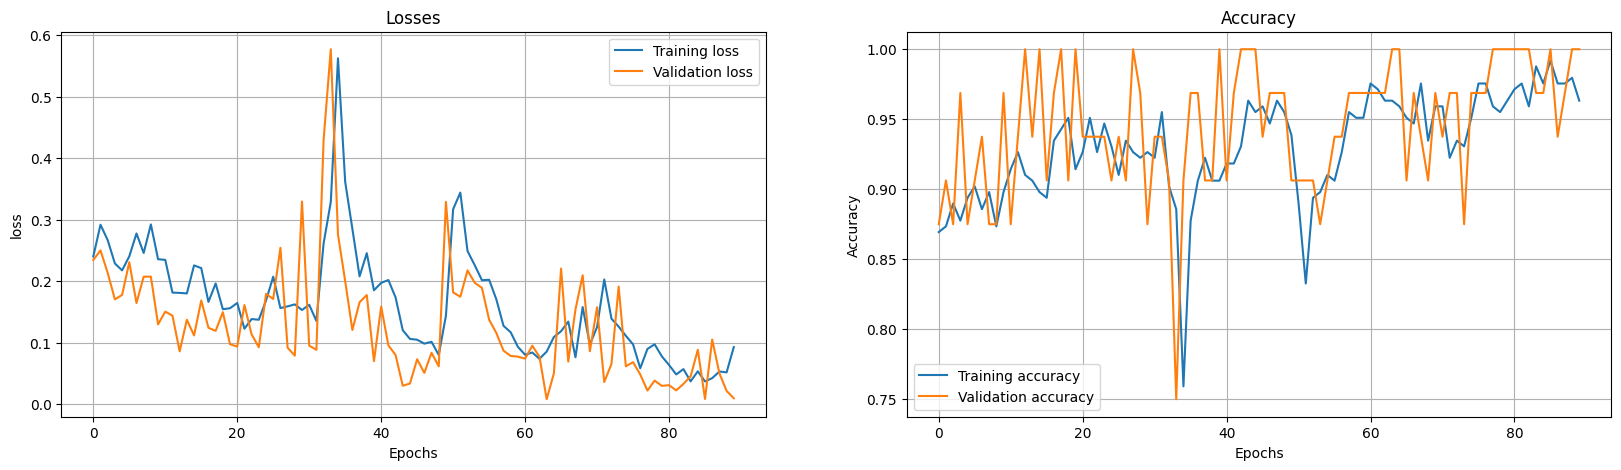

In [ ]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

# **TESTING THE MODEL BY PREDICTING**

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First Image to Predict :")
    plt.imshow(first_image)
    print("\nActual label:",class_names[first_label])
    batch_prediction = model. predict (images_batch)
    print("\nPredicted label" ,class_names[np.argmax(batch_prediction[0])])

NameError: ignored

In [ ]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 [==============================] - 0s 57ms/step


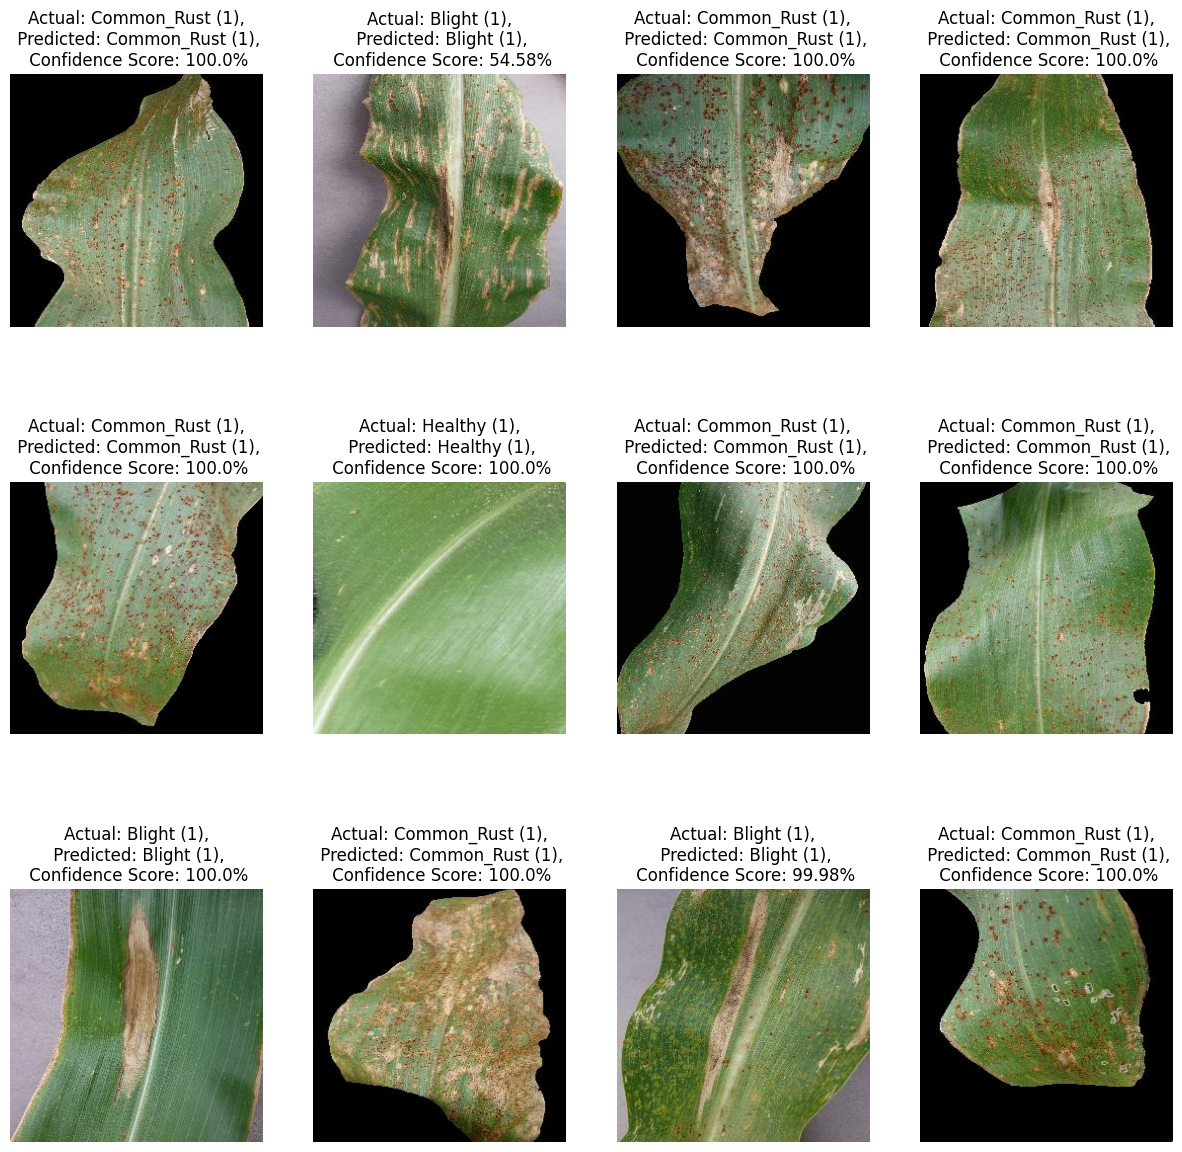

In [ ]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")